In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

df=pd.read_csv('11yrs_data.csv')
df['Date'] = pd.to_datetime(df['Date'],format='%d-%m-%Y',errors='coerce')
df.set_index(df['Date'],inplace=True) 

In [2]:
df1=df[df.index.month == 6]    
df1[['Temp_min']]

,Temp_min
Date,
2011-06-01,48
2011-06-02,48
2011-06-03,52
2011-06-04,55
2011-06-05,57
...,...
2021-06-26,84
2021-06-27,84
2021-06-28,82


## EDA

<AxesSubplot:xlabel='Date'>

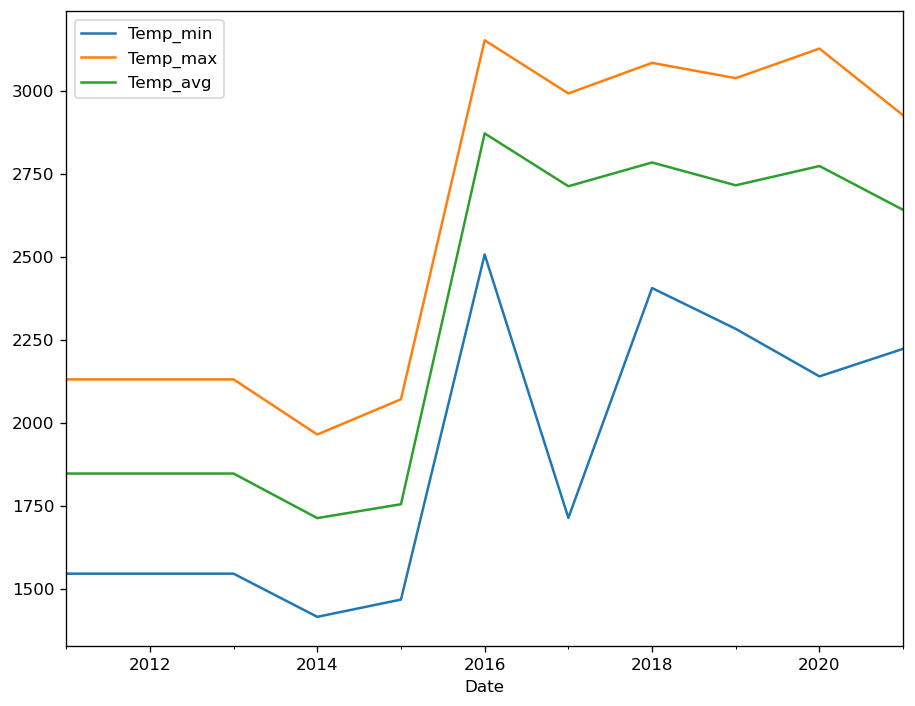

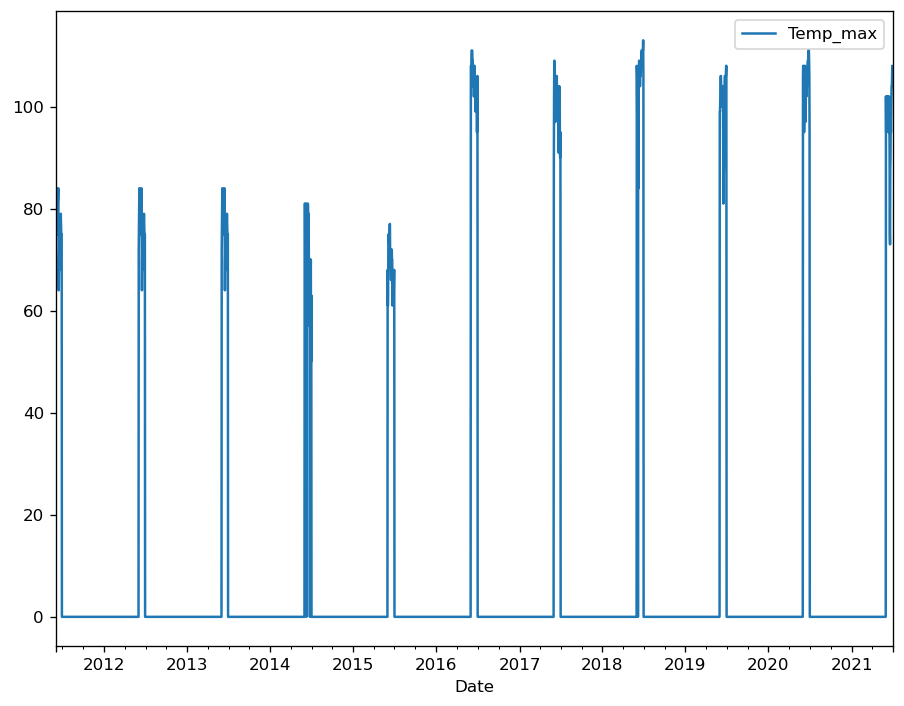

In [29]:
yearly=df1[['Temp_min','Temp_max','Temp_avg']].resample('Y').sum()
mor_noon_night=df1[['Temp_max']].resample('D').sum()

yearly.plot()
mor_noon_night.plot()

##### Let's checkout the most common weather condition type in JAIPUR in JUNE.

Text(0, 0.5, 'Percent')

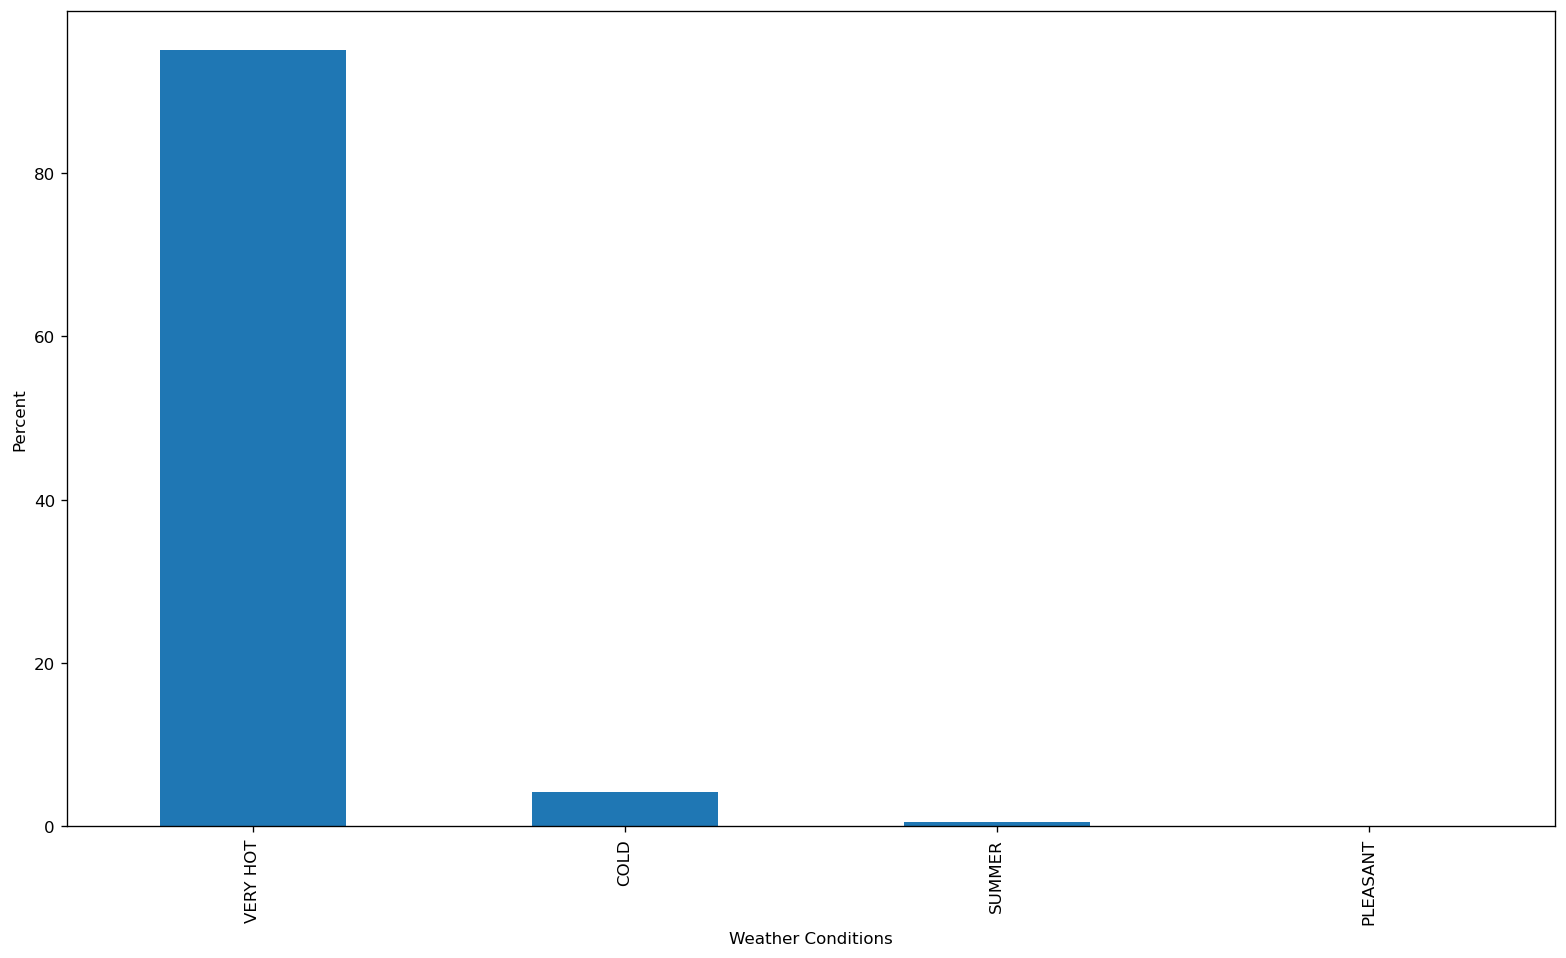

In [30]:
def vivek_singh(temp):
    if (temp <= 20) :
        return "COLD"
    elif (temp >= 21 and temp <= 35):
        return "PLEASANT"
    elif (temp >= 36 and temp <=42):
        return "SUMMER"
    elif (temp >= 47 and temp <= 100):
        return "VERY HOT"
    

vivek1 = df['Temp_max'].apply(vivek_singh)
vivek2= df['Temp_min'].apply(vivek_singh)

weather_condition = (vivek2.value_counts()/(vivek2.value_counts().sum()))*100
weather_condition.plot.bar(figsize=(16,9))
plt.xlabel('Weather Conditions')
plt.ylabel('Percent')


## CHECK STATIONARY after doing EDA work

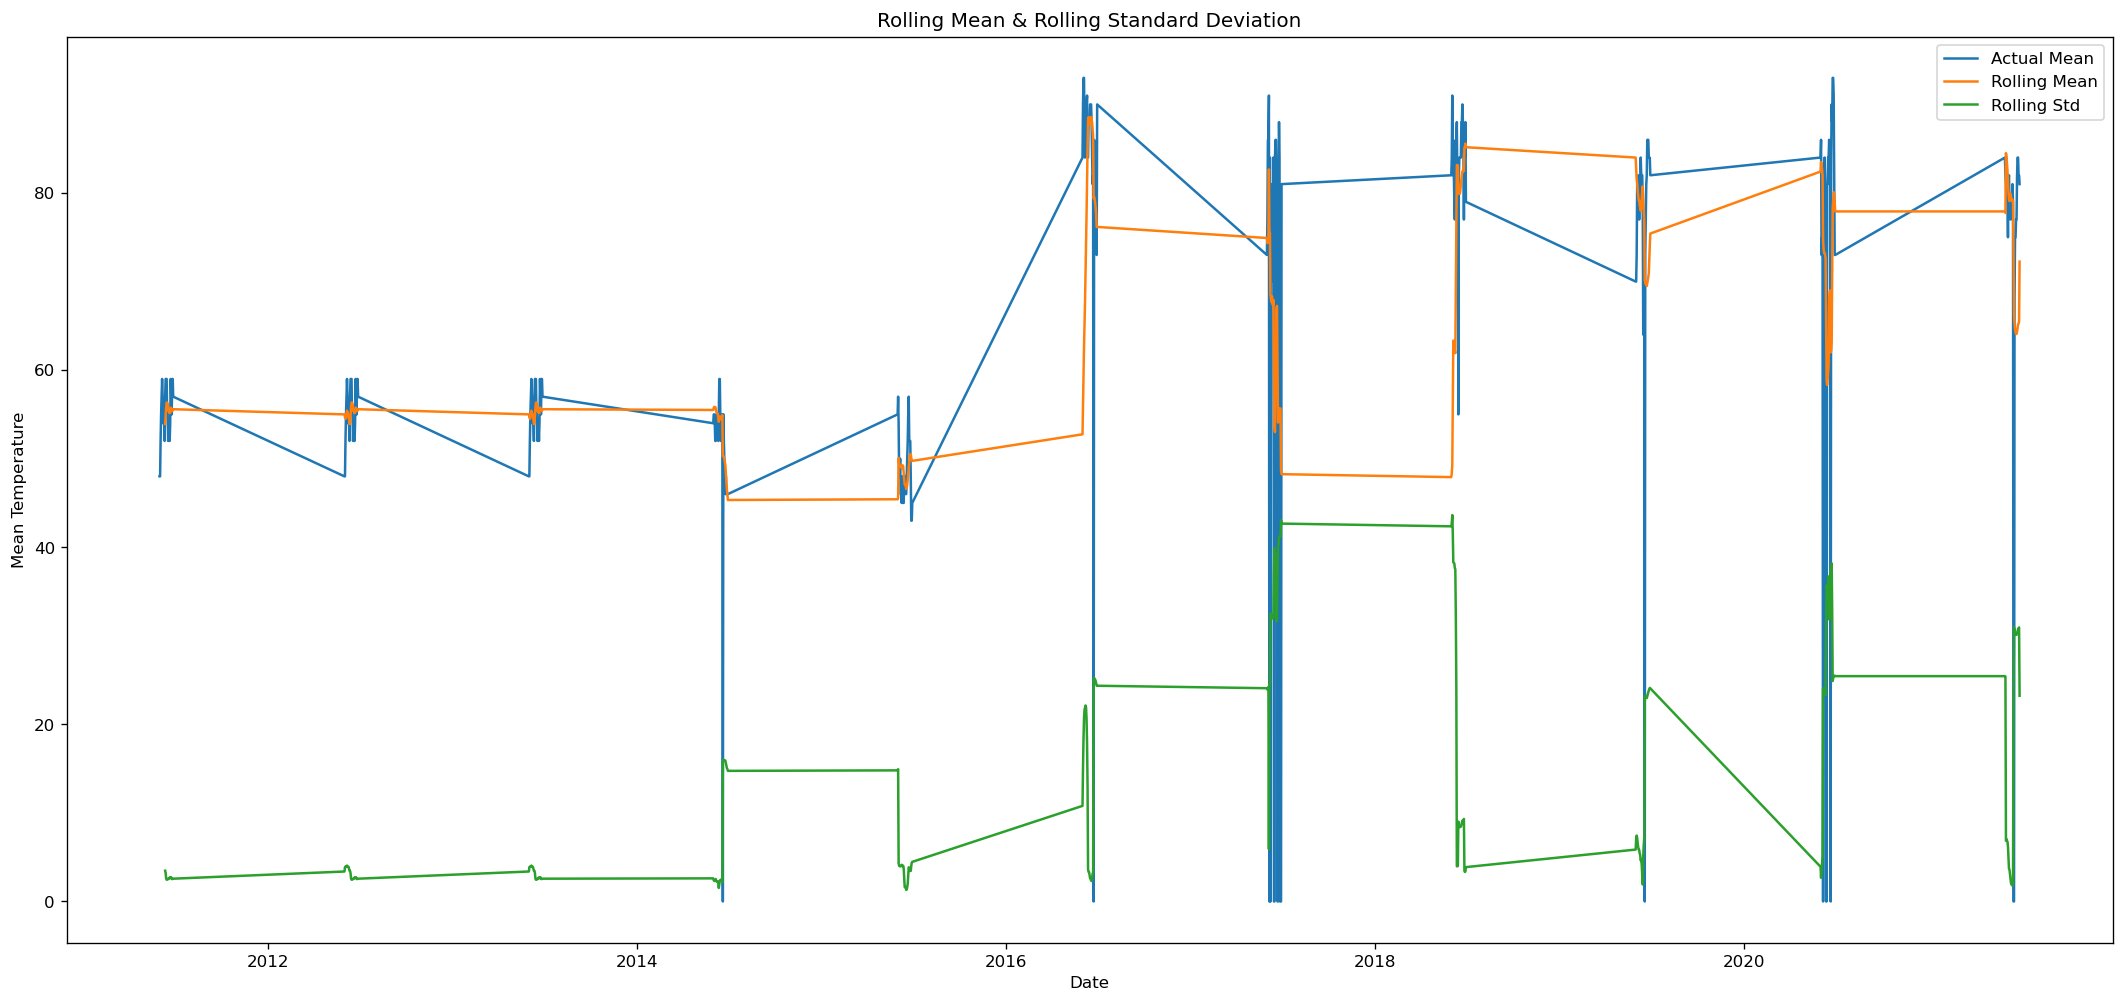

ADF Test Statistic : -3.221598008305982
p-value : 0.01876804937734513
#Lags Used : 6
Number of Observations : 314
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [31]:
# check rolling mean and rolling standard deviation
def plot_rolling_mean_std(ts):
    rolling_mean = ts.rolling(12).mean()
    rolling_std = ts.rolling(12).std()
    plt.figure(figsize=(22,10))

    plt.plot(ts, label='Actual Mean')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()
###########################################################################################################
from statsmodels.tsa.stattools import adfuller, acf, pacf
test_result=adfuller(df1['Temp_min'])

def adfuller_test(unit):
    result=adfuller(unit)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):  #zip=concat
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")
####################################################################################################################
plot_rolling_mean_std(df1['Temp_min'])
adfuller_test(df1['Temp_min'])

## MAKE STATIONARY BY USING ANY OF THEM
## 1. Decomposing  = additive ,multiplicative
###### from statsmodels.tsa.seasonal import seasonal_decompose
###### result = seasonal_decompose(x=df['temp_min'],period=1,model='additive')
## 2. Differencing  = IST ORDER , 2ND ORDER DIFFERENCING
## 3. np.log(df['tempt'])

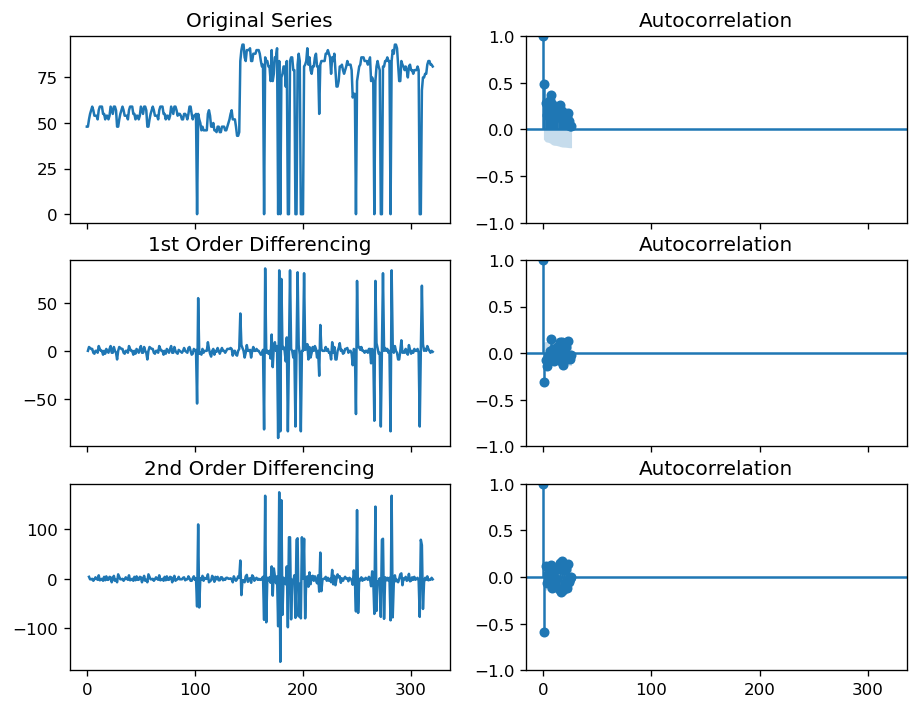

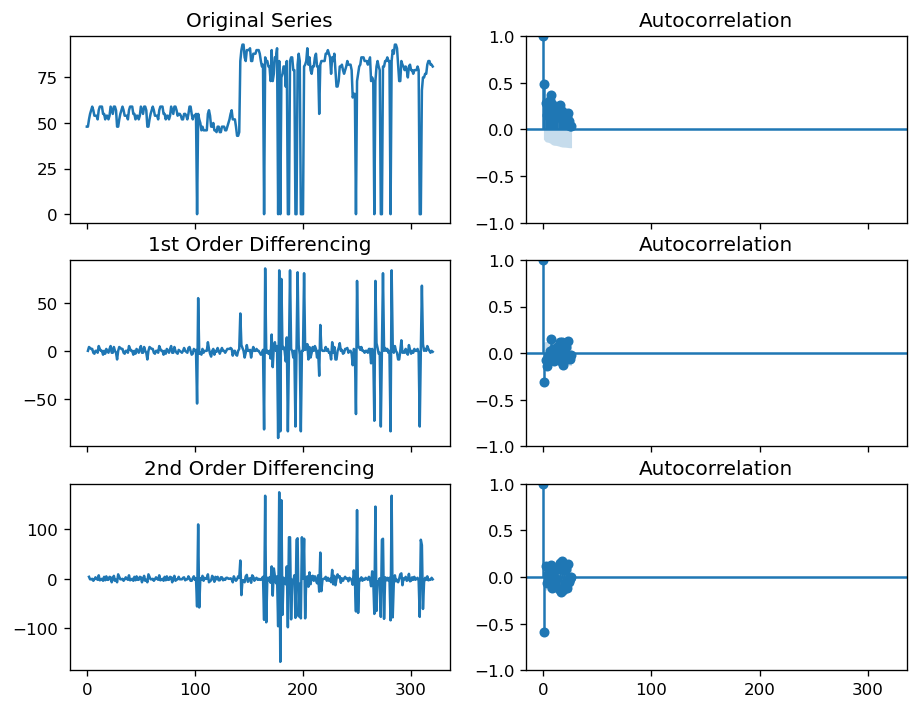

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Original Series
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df1[['Temp_min']].values); 
axes[0, 0].set_title('Original Series')
plot_acf(df1[['Temp_min']].values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df1[['Temp_min']].diff().values); 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df1[['Temp_min']].diff().dropna().values,ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df1[['Temp_min']].diff().diff().values); 
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df1[['Temp_min']].diff().diff().dropna().values,ax=axes[2, 1])


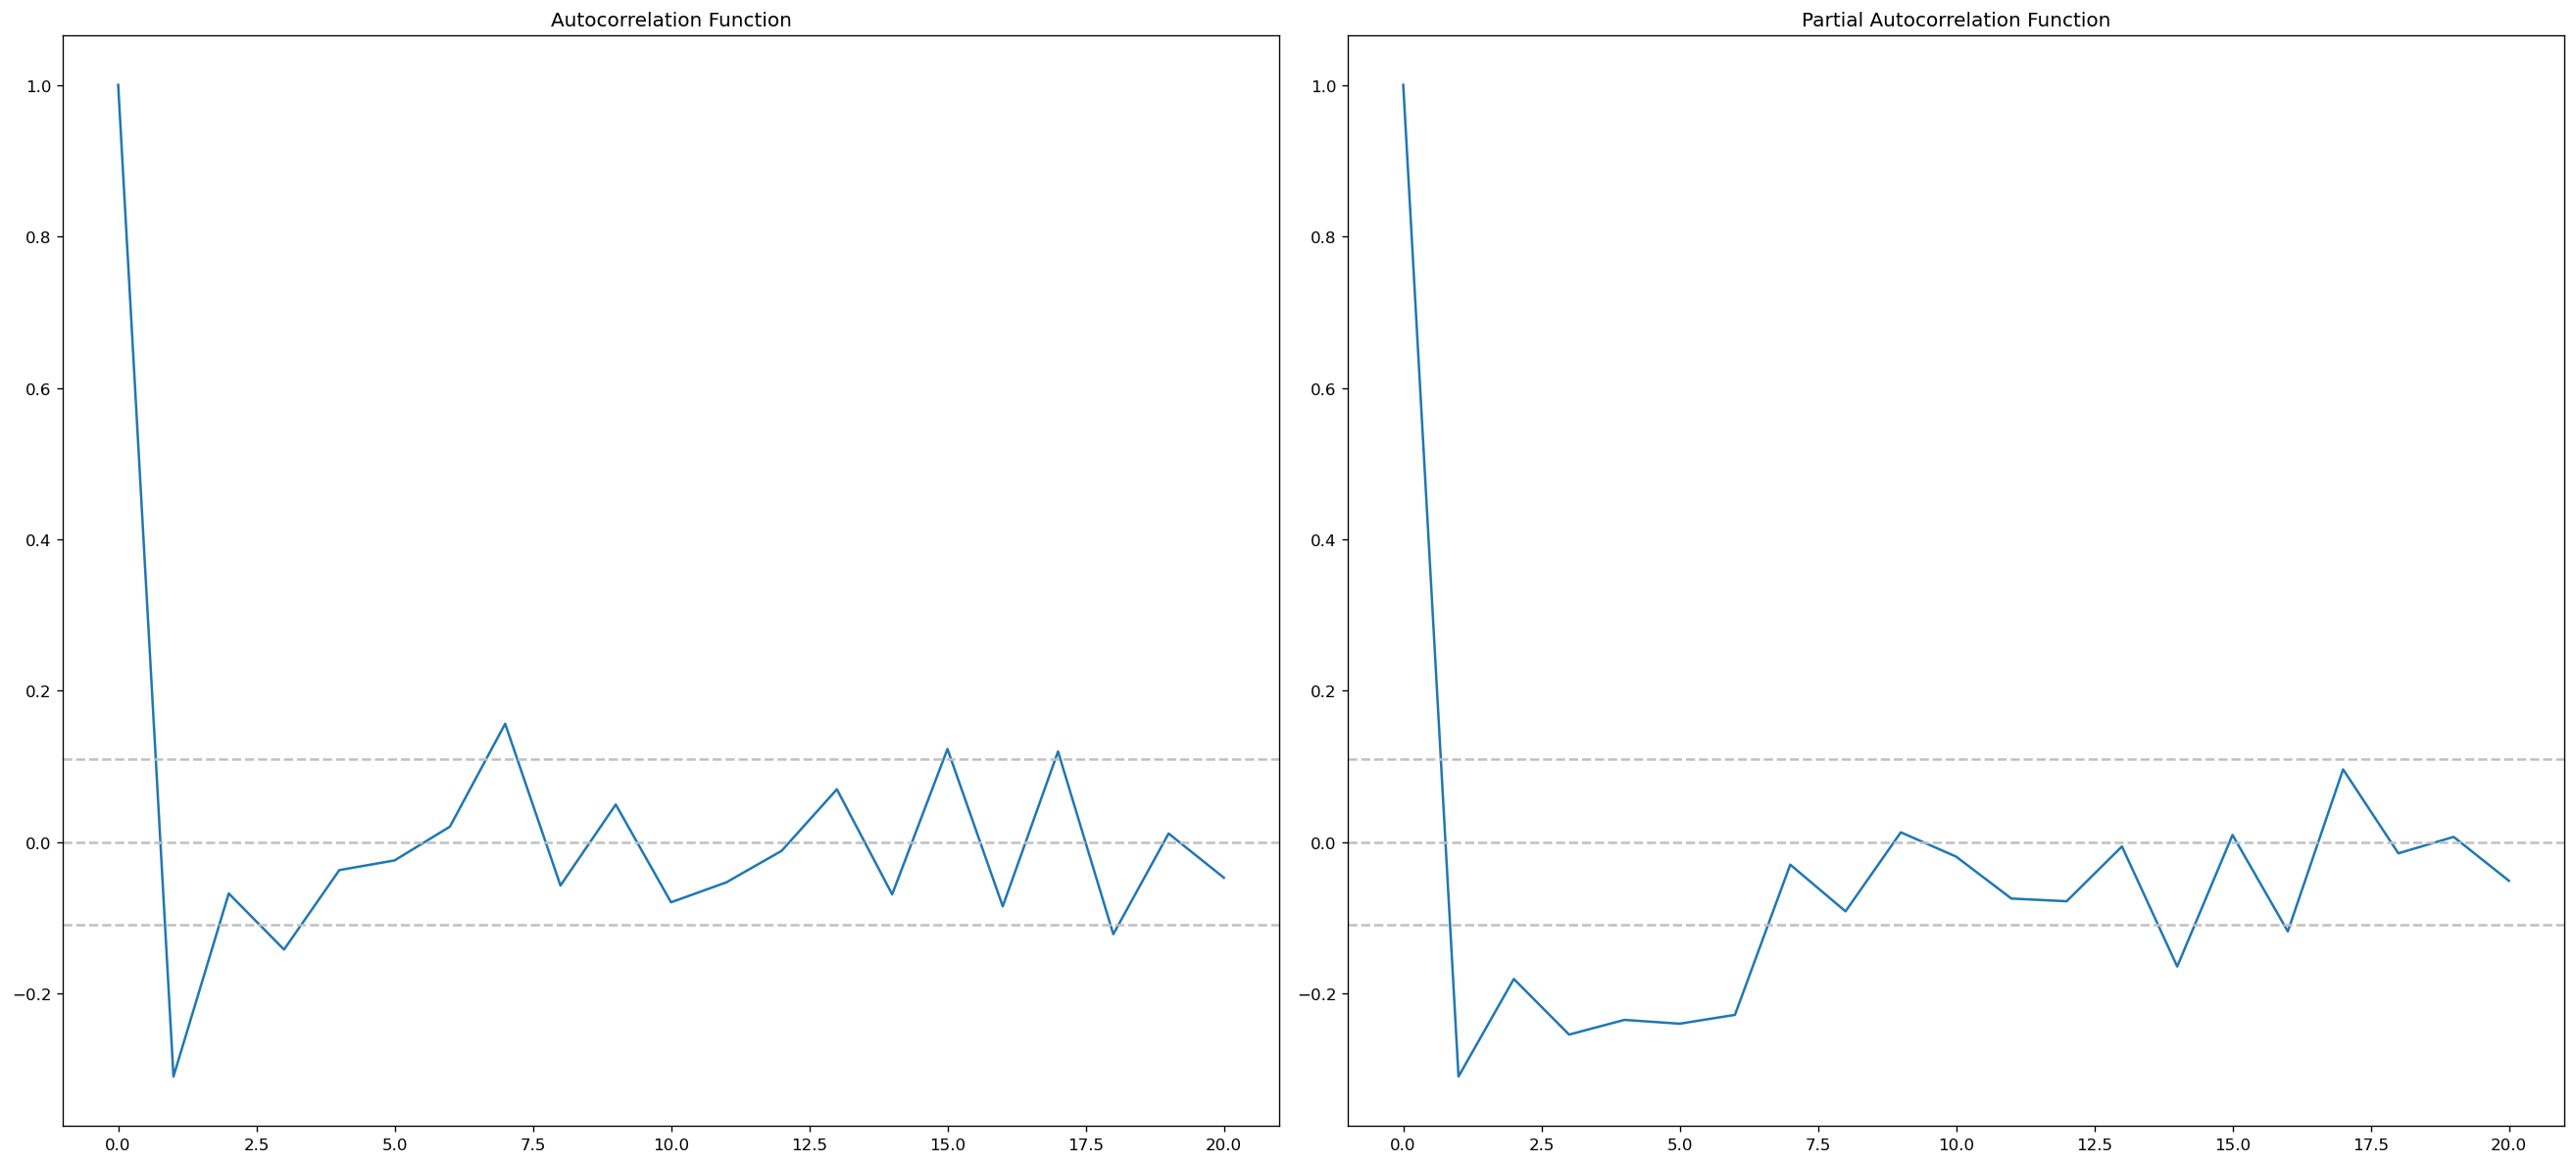

In [33]:
acf_lag = acf(df1[['Temp_min']].diff().dropna().values, nlags=20)
pacf_lag = pacf(df1[['Temp_min']].diff().dropna().values, nlags=20, method='ols')

plt.figure(figsize=(22,10))

plt.subplot(121)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(df1[['Temp_min']].diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(df1[['Temp_min']].diff().values)),linestyle='--',color='silver')
plt.title("Autocorrelation Function")

plt.subplot(122)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(df1[['Temp_min']].diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(df1[['Temp_min']].diff().values)),linestyle='--',color='silver')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

#### These grey dotted line are confidence intervels which we are going to use to find out the value of p and q.

## p - the point where PACF crosses the upper confiednce level. In our case it seems to be 18. So we will take p = 18.

## q - the point where ACF crosses the upper confiednce level. In our case it seems to be  6. So we will take q = 6.

## d - number of nonseasonal differences needed for stationarity. In this case we are going to take it as 0, since this series is already stationary.   I THINK D=2

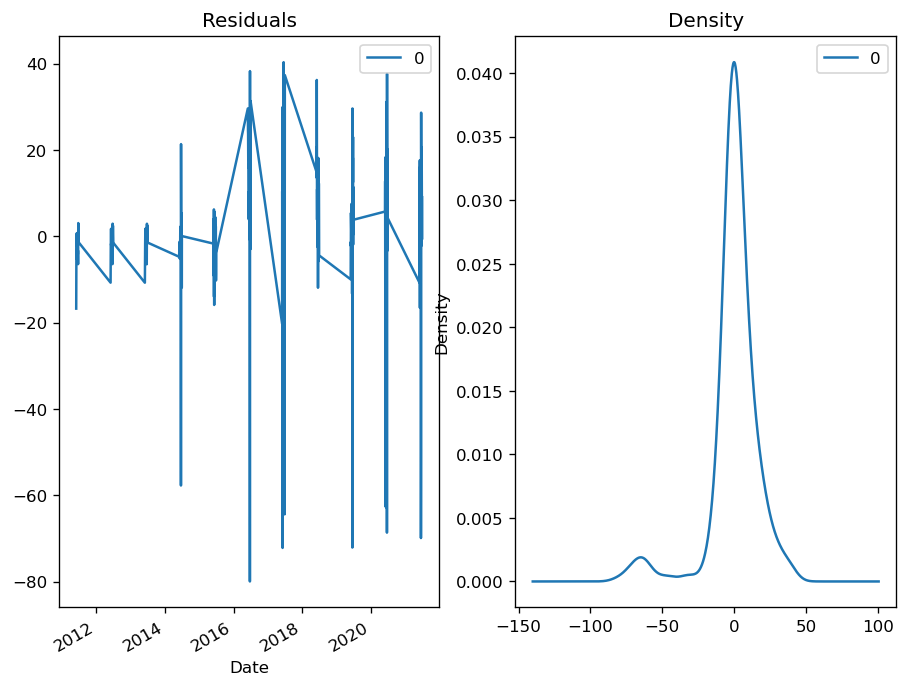

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Temp_min   No. Observations:                  321
Model:                ARIMA(18, 0, 6)   Log Likelihood               -1369.763
Date:                Wed, 09 Feb 2022   AIC                           2791.525
Time:                        17:22:13   BIC                           2889.583
Sample:                             0   HQIC                          2830.677
                                - 321                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.7810      7.499      8.639      0.000      50.084      79.478
ar.L1          0.3747      1.491      0.251      0.802      -2.548       3.298
ar.L2         -0.1345      0.659     -0.204      0.838      -1.425       1.156
ar.L3          0.0715      0.751      0.095      0.924      -1.400       1.543
ar.L4         -0.0806      0.470     -0.172      0.864      -1.001       0.840
ar.L5         -0.0987      0.437     -0.226      0.821      -0.956       0.759
ar.L6          0.7065      0.539      1.312      0.190      -0.349       1.762
ar.L7         -0.0173      0.566     -0.031      0.976      -1.126       1.091
ar.L8         -0.0780      0.482     -0.162      0.872      -1.023       0.867
ar.L9          0.1536      0.252      0.611      0.541      -0.339       0.647
ar.L10        -0.0906      0.428     -0.212      0.832      -0.929       0.748
ar.L11         0.0028      0.224      0.013      0.990      -0.436       0.442
ar.L12         0.0064      0.208      0.031      0.976      -0.402       0.415
ar.L13        -0.0457      0.164     -0.279      0.780      -0.367       0.275
ar.L14        -0.0171      0.091     -0.189      0.850      -0.195       0.161
ar.L15         0.0787      0.061      1.285      0.199      -0.041       0.199
ar.L16        -0.0622      0.161     -0.387      0.699      -0.377       0.253
ar.L17         0.2001      0.074      2.703      0.007       0.055       0.345
ar.L18        -0.1485      0.325     -0.456      0.648      -0.786       0.489
ma.L1          0.0543      1.489      0.036      0.971      -2.863       2.972
ma.L2          0.1433      1.274      0.112      0.910      -2.354       2.640
ma.L3         -0.0262      1.261     -0.021      0.983      -2.497       2.445
ma.L4          0.0840      0.945      0.089      0.929      -1.768       1.936
ma.L5          0.2260      0.794      0.285      0.776      -1.330       1.782
ma.L6         -0.5793      0.992     -0.584      0.559      -2.523       1.364
sigma2       291.7826     19.340     15.087      0.000     253.876     329.689
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               905.13
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               7.82   Skew:                            -2.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

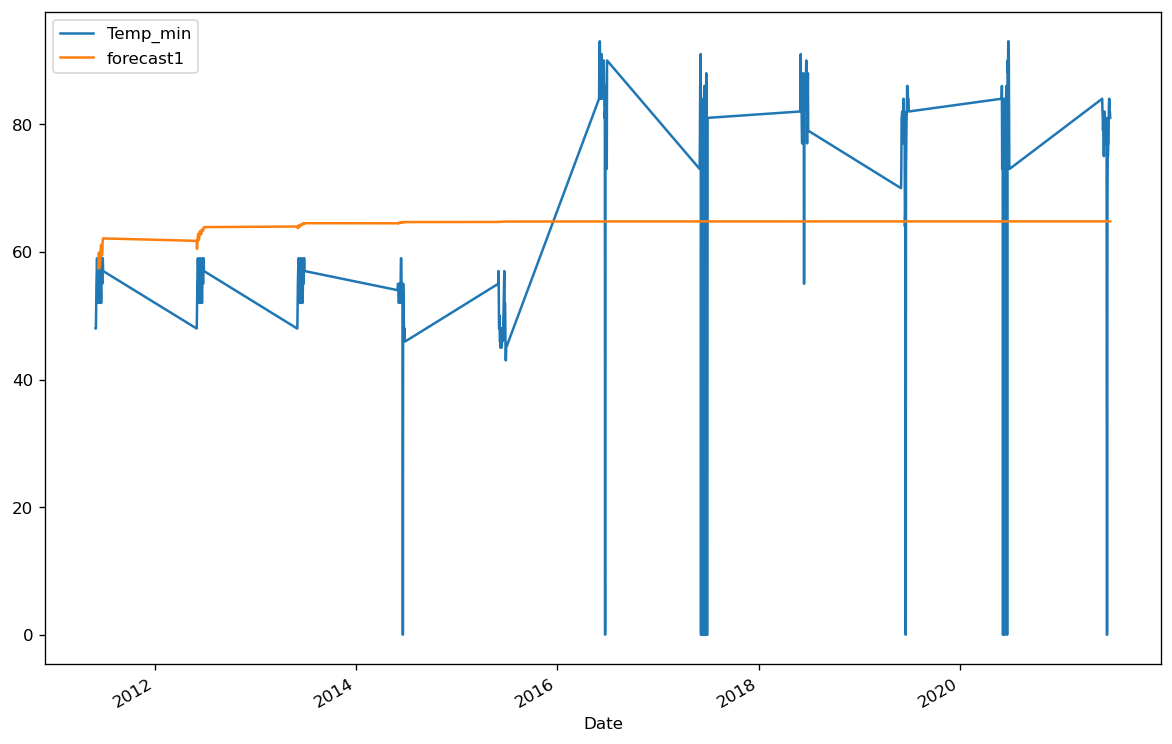

In [41]:
import statsmodels.api as sm

# 1,0,2 ARIMA Model
model1 = sm.tsa.arima.ARIMA(df1['Temp_min'], order=(18,0,6))
model_fit1 = model1.fit()


# 1,1,1 ARIMA Model
model2 = sm.tsa.arima.ARIMA(df1['Temp_min'], order=(9,1,2))
model_fit2 = model2.fit()
#model_fit2.summary()

# Plot residual errors
residuals = pd.DataFrame(model_fit1.resid)    # model_fit1 ka error
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# Actual vs Fitted
df1['forecast1']=model_fit1.predict(start=10,end=320,dynamic=True)
df1[['Temp_min','forecast1']].plot(figsize=(12,8))

model_fit1.summary()

#error = mean_squared_error(test_df, forecast)
#print('Test Mean Squared Error: ',error)

In [51]:
print(model_fit1.forecast(steps=7))

321    75.080586
322    76.246498
323    67.810500
324    71.834595
325    68.314677
326    65.884916
327    80.232043
Name: predicted_mean, dtype: float64


## SARIMAX

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           Temp_min   No. Observations:                  321
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1352.945
Date:                            Wed, 09 Feb 2022   AIC                           2715.890
Time:                                    17:21:27   BIC                           2734.541
Sample:                                         0   HQIC                          2723.348
                                            - 321                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3124      0.048      6.526      0.000       0.219       0.406
ma.L1         -0.9183      0.027    -34.187      0.000      -0.971      -0.866
ar.S.L12      -0.0544      0.056     -0.974      0.330      -0.164       0.055
ma.S.L12      -0.9620      0.087    -11.084      0.000      -1.132      -0.792
sigma2       343.9791     22.174     15.513      0.000     300.519     387.439
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              1200.57
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               9.88   Skew:                            -2.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

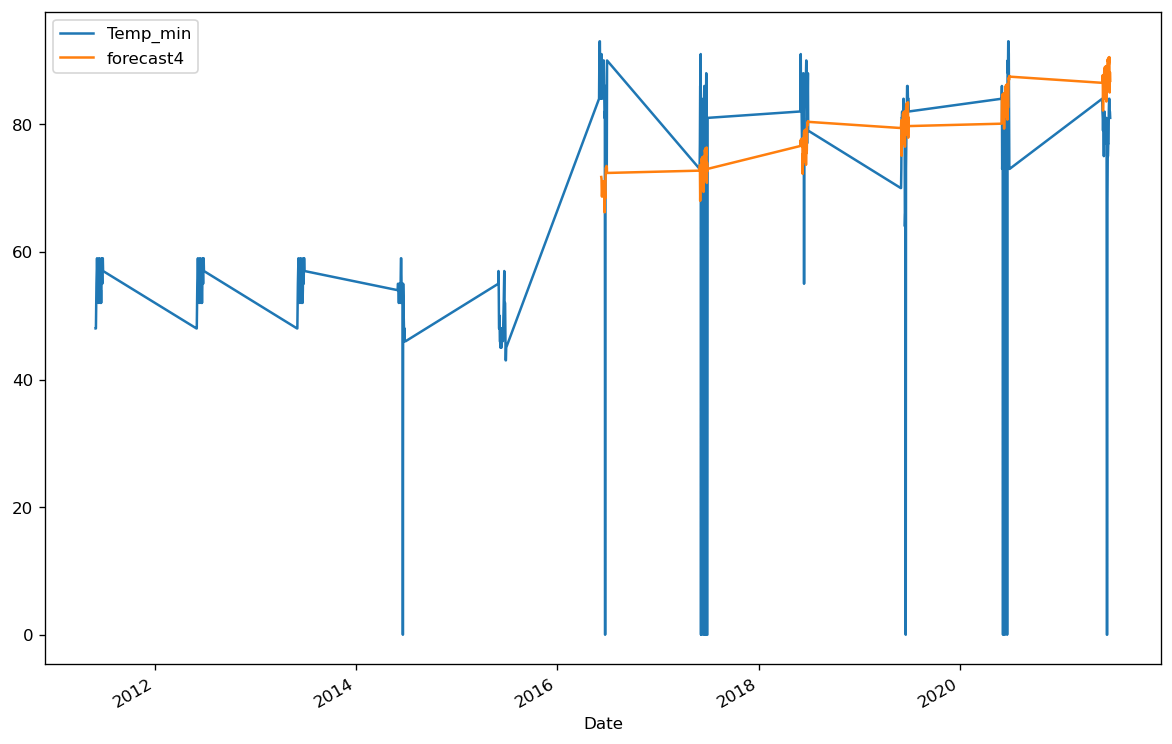

In [40]:
import statsmodels.api as sm
model3=sm.tsa.statespace.SARIMAX(df1['Temp_min'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
model_fit3=model3.fit()


df1['forecast4']=model_fit3.predict(start=150,end=320,dynamic=True)
df1[['Temp_min','forecast4']].plot(figsize=(12,8))
model_fit3.summary()

In [52]:
print(model_fit3.forecast(steps=7))

321    73.452025
322    83.117118
323    78.009932
324    81.722190
325    78.454716
326    74.715154
327    81.406396
Name: predicted_mean, dtype: float64
